# Image Classifier

## Libraries

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
import torchvision
from torchvision import datasets, transforms
import torch.utils
import torch.utils.data 
import torch.utils.data.dataloader
import torchvision.models.resnet

from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.metrics import f1_score
from itertools import groupby

In [2]:
print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.4.0


In [3]:
print(f"Is MPS built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set device
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Is MPS built? True
Is MPS available? True
Using device: mps


In [4]:
x = torch.rand(size=(3, 4)).to(device)
x

tensor([[0.0554, 0.1935, 0.6934, 0.0792],
        [0.0181, 0.0469, 0.6590, 0.7149],
        [0.9055, 0.4539, 0.8399, 0.0409]], device='mps:0')

## Data

In [ ]:
transform = transforms.Compose([transforms.Resize((300, 300)),
                                #transforms.CenterCrop(300),
                                transforms.ToTensor()])

parent_directory = os.path.abspath(os.path.join(os.getcwd(), '..'))
relative_folderpath_s = os.path.join(parent_directory, 'data/segmented/graph/spec')
relative_folderpath_p = os.path.join(parent_directory, 'data/segmented/graph/pl')

dataset = datasets.ImageFolder(relative_folderpath_p, transform=transform)

batchSize = 16

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=True, num_workers=4)

torch.Size([3, 1000, 1000])
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])
1
Dataset ImageFolder
    Number of datapoints: 899
    Root location: /Users/davidpichler/GitHubRepo/Thesis/data/segmented/graph/pl
    StandardTransform
Transform: Compose(
           

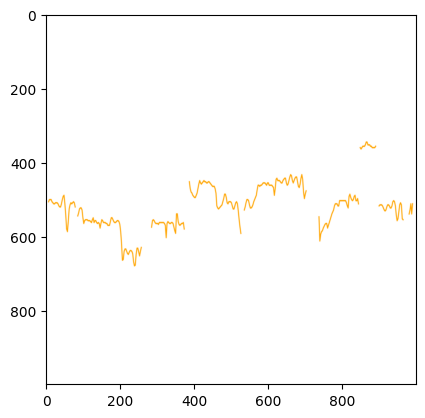

In [46]:
img, labels = dataset[300]
print(img.shape)
print(img)
print(labels)
plt.imshow(img.permute(1,2,0))
print(dataset)
print(dataset.class_to_idx)

In [47]:
images_batch, labels_batch = next(iter(dataloader))
images_batch

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]],


        [[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
        

In [33]:
labels_batch.shape

torch.Size([16])

In [34]:
labels_batch

tensor([0, 0, 0, 0, 1, 1, 0, 2, 2, 0, 2, 1, 0, 1, 1, 1])

In [35]:
img = torchvision.utils.make_grid(images_batch)

In [36]:
img.shape

torch.Size([3, 426, 1698])

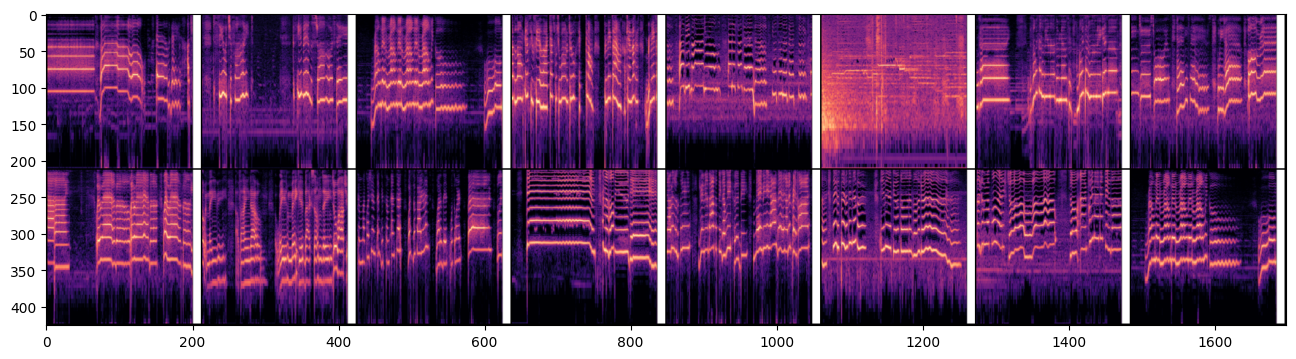

In [37]:
img = np.transpose(img, (1, 2, 0))
plt.figure(figsize=(16, 12))
plt.imshow(img)

In [38]:
from torch.utils.data import random_split

random_seed = 2024
torch.manual_seed(random_seed)

# Define the sizes of the train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset into train and test sets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
print('Train Dataset: ' + str(len(train_dataset)))
print('Test Dataset: ' + str(len(test_dataset)))

# Create dataloaders for train and test sets


Train Dataset: 40612
Test Dataset: 10153


## CNN

In [39]:
'''class ConvolutionalNeuralNet():
  def __init__(self, network):
    self.network = network.to(device)
    self.optimizer = torch.optim.Adam(self.network.parameters(), lr=1e-3)

  def train(self, loss_function, epochs, batch_size, 
            training_set, validation_set):
    
    #  creating log
    log_dict = {
        'training_loss_per_batch': [],
        'validation_loss_per_batch': [],
        'training_accuracy_per_epoch': [],
        'validation_accuracy_per_epoch': []
    } 

    #  defining weight initialization function
    def init_weights(module):
      if isinstance(module, nn.Conv2d):
        torch.nn.init.xavier_uniform_(module.weight)
        module.bias.data.fill_(0.01)
      elif isinstance(module, nn.Linear):
        torch.nn.init.xavier_uniform_(module.weight)
        module.bias.data.fill_(0.01)

    #  defining accuracy function
    def accuracy(network, dataloader):
      network.eval()
      total_correct = 0
      total_instances = 0
      for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)
        predictions = torch.argmax(network(images), dim=1)
        correct_predictions = sum(predictions==labels).item()
        total_correct+=correct_predictions
        total_instances+=len(images)
      return round(total_correct/total_instances, 3)

    #  initializing network weights
    self.network.apply(init_weights)

    #  creating dataloaders
    train_loader = DataLoader(training_set, batch_size)
    val_loader = DataLoader(validation_set, batch_size)

    #  setting convnet to training mode
    self.network.train()

    for epoch in range(epochs):
      print(f'Epoch {epoch+1}/{epochs}')
      train_losses = []

      #  training
      print('training...')
      for images, labels in tqdm(train_loader):
        #  sending data to device
        images, labels = images.to(device), labels.to(device)
        #  resetting gradients
        self.optimizer.zero_grad()
        #  making predictions
        predictions = self.network(images)
        #  computing loss
        loss = loss_function(predictions, labels)
        log_dict['training_loss_per_batch'].append(loss.item())
        train_losses.append(loss.item())
        #  computing gradients
        loss.backward()
        #  updating weights
        self.optimizer.step()
      with torch.no_grad():
        print('deriving training accuracy...')
        #  computing training accuracy
        train_accuracy = accuracy(self.network, train_loader)
        log_dict['training_accuracy_per_epoch'].append(train_accuracy)

      #  validation
      print('validating...')
      val_losses = []

      #  setting convnet to evaluation mode
      self.network.eval()

      with torch.no_grad():
        for images, labels in tqdm(val_loader):
          #  sending data to device
          images, labels = images.to(device), labels.to(device)
          #  making predictions
          predictions = self.network(images)
          #  computing loss
          val_loss = loss_function(predictions, labels)
          log_dict['validation_loss_per_batch'].append(val_loss.item())
          val_losses.append(val_loss.item())
        #  computing accuracy
        print('deriving validation accuracy...')
        val_accuracy = accuracy(self.network, val_loader)
        log_dict['validation_accuracy_per_epoch'].append(val_accuracy)

      train_losses = np.array(train_losses).mean()
      val_losses = np.array(val_losses).mean()

      print(f'training_loss: {round(train_losses, 4)}  training_accuracy: '+
      f'{train_accuracy}  validation_loss: {round(val_losses, 4)} '+  
      f'validation_accuracy: {val_accuracy}\n')
      
    return log_dict

  def predict(self, x):
    return self.network(x)'''

"class ConvolutionalNeuralNet():\n  def __init__(self, network):\n    self.network = network.to(device)\n    self.optimizer = torch.optim.Adam(self.network.parameters(), lr=1e-3)\n\n  def train(self, loss_function, epochs, batch_size, \n            training_set, validation_set):\n    \n    #  creating log\n    log_dict = {\n        'training_loss_per_batch': [],\n        'validation_loss_per_batch': [],\n        'training_accuracy_per_epoch': [],\n        'validation_accuracy_per_epoch': []\n    } \n\n    #  defining weight initialization function\n    def init_weights(module):\n      if isinstance(module, nn.Conv2d):\n        torch.nn.init.xavier_uniform_(module.weight)\n        module.bias.data.fill_(0.01)\n      elif isinstance(module, nn.Linear):\n        torch.nn.init.xavier_uniform_(module.weight)\n        module.bias.data.fill_(0.01)\n\n    #  defining accuracy function\n    def accuracy(network, dataloader):\n      network.eval()\n      total_correct = 0\n      total_instances 

In [40]:
import torch.nn as nn
import torch.nn.functional as F

In [41]:
in_size = 3 # RGB images

hid1_size = 16 # number of filters
hid2_size = 32  # number of filters
hid3_size = 64  # number of filters

out_size = 3 # num of classes

k_conv_size = 3 # conv kernel size


In [42]:

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batchSize, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batchSize, shuffle=True, num_workers=4)

In [43]:
class ConvNet(nn.Module):    
    # Constructor
    def __init__(self):
        super(ConvNet, self).__init__()

        # Convolution 1
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_size, hid1_size, kernel_size=k_conv_size),
            nn.BatchNorm2d(hid1_size),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2))
        
        # Convolution 2
        self.layer2 = nn.Sequential(
            nn.Conv2d(hid1_size, hid2_size, kernel_size=k_conv_size),
            nn.BatchNorm2d(hid2_size),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2))
        
        # Convolution 3
        self.layer3 = nn.Sequential(
            nn.Conv2d(hid2_size, hid3_size, kernel_size=k_conv_size),
            nn.BatchNorm2d(hid3_size),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2))
        
        # Flatten
        self.flatten = nn.Flatten()

        # Dropout
        self.dropout = nn.Dropout(0.2)

        # Fully connected 1
        self.fc1 = nn.Linear(36864, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, out_size)
    
    # Forward function
    def forward(self, x):
        out = self.layer1(x) # conv1
        out = self.layer2(out) # conv2
        out = self.layer3(out) # conv3
        out = self.flatten(out) # flatten
        out = self.dropout(out) # dropout
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
 
        return out

In [44]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(18432, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 2)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out


In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the basic block for ResNet
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# Define the ResNet-18 model
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=2):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out



In [46]:
# Create the network
model = ConvNet()
#model = ResNet(BasicBlock, [2, 2, 2, 2])

# Move the network to the device
model = model.to(device)

In [47]:
# learning rate
learning_rate = 0.001

# Loss funciton
criterion = nn.CrossEntropyLoss()
#criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [48]:
num_epochs = 20

acc = []
roc = []
loss_values = []


In [49]:
def validate(model, loader):
    correct = 0
    total = 0
    
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            # Send data to device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
    return correct / total

In [50]:
# Lists to store predictions and true labels
all_preds = []
all_labels = []

for epoch in range(num_epochs):
    model.train()
    for img, labels in train_loader: 
        img, labels = img.to(device), labels.to(device)
        
        outputs = model(img)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store predictions and true labels
        all_preds.extend(outputs.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())

    train_accuracy = validate(model, train_loader)
        
    loss_values.append(loss.item())
    acc.append(train_accuracy)

    #if epoch % 5 == 0: 
    print(f'Epoch: {epoch + 1} | Loss: {loss.item()}' + f' | Train Accuracy:  {train_accuracy}')

test_acc = validate(model, test_loader)
print(f'Test Accuracy: {test_acc}')

Epoch: 1 | Loss: 0.5711266398429871 | Train Accuracy:  0.6953856003151778
Epoch: 2 | Loss: 0.20522750914096832 | Train Accuracy:  0.9319659214025411
Epoch: 3 | Loss: 0.22007127106189728 | Train Accuracy:  0.9531173052299813
Epoch: 4 | Loss: 0.3812539875507355 | Train Accuracy:  0.958903772284054
Epoch: 5 | Loss: 0.42620983719825745 | Train Accuracy:  0.9666108539347976
Epoch: 6 | Loss: 0.0538986474275589 | Train Accuracy:  0.9643208903772285
Epoch: 7 | Loss: 0.014052051119506359 | Train Accuracy:  0.967595784497193
Epoch: 8 | Loss: 0.06768503040075302 | Train Accuracy:  0.9702304737516005
Epoch: 9 | Loss: 1.6659003449603915e-05 | Train Accuracy:  0.9727912932138284
Epoch: 10 | Loss: 6.409835623344406e-05 | Train Accuracy:  0.9725696838372895


KeyboardInterrupt: 

## Evaluation

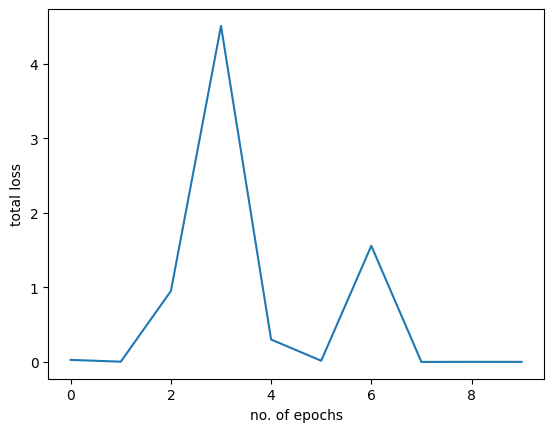

In [ ]:
plt.plot(loss_values)
plt.xlabel("no. of epochs")
plt.ylabel("total loss")
plt.show()

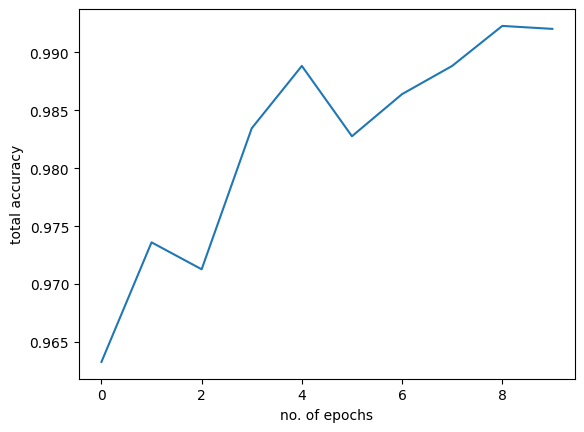

In [ ]:
plt.plot(acc)
plt.xlabel("no. of epochs")
plt.ylabel("total accuracy")
plt.show()

In [ ]:
model.eval()

with torch.no_grad():
   correct = 0
   total = 0
   true_labels = []
   predicted_labels = []

   for X_test_tensor, Y_test_tensor in test_loader:
      X_test_tensor, Y_test_tensor = X_test_tensor.to(device), Y_test_tensor.to(device)
      outputs = model(X_test_tensor)
      _, predicted = torch.max(outputs.data, 1)

      y_test = Y_test_tensor.cpu().numpy()
      predicted = predicted.cpu().numpy()

      correct += (predicted == y_test).sum().item()
      total += len(y_test)


      true_labels.extend(y_test)
      predicted_labels.extend(predicted)

   unique, counts = np.unique(predicted_labels, return_counts=True)

   print(f'Predicted labels: {dict(zip(unique, counts))}')

   unique, counts = np.unique(true_labels, return_counts=True)
   print(f'True labels: {dict(zip(unique, counts))}')

   accuracy = correct / total

   f1 = f1_score(true_labels, predicted_labels)

   print(f'Accuracy: {accuracy}')

   print(f'F1 Score: {f1}')


Predicted labels: {0: 3362, 1: 3515}
True labels: {0: 3366, 1: 3511}
Accuracy: 0.9936018612767195
F1 Score: 0.9937375462567606


In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix

# Create a DataFrame from the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
cm_df = pd.DataFrame(cm, index=['Actual Corrected', 'Actual Original'], columns=['Predicted Corrected', 'Predicted Original'])

# Display the DataFrame
print(cm_df)


                  Predicted Corrected  Predicted Original
Actual Corrected                 3342                  24
Actual Original                    20                3491


In [ ]:
# Plot ROC curve
'''plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
'''

'plt.figure()\nplt.plot(fpr, tpr, label=\'ROC curve (AUC = %0.2f)\' % roc_auc)\nplt.plot([0, 1], [0, 1], \'k--\')\nplt.xlim([0.0, 1.0])\nplt.ylim([0.0, 1.05])\nplt.xlabel(\'False Positive Rate\')\nplt.ylabel(\'True Positive Rate\')\nplt.title(\'Receiver Operating Characteristic\')\nplt.legend(loc="lower right")\nplt.show()\n'